In [70]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import math
import random
from itertools import count
from collections import namedtuple, deque

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [71]:
filename = "EURUSD_M1_2023.csv"

df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']) 

#timestamp as index
df.set_index('timestamp', inplace=True)
# data = df.resample('5min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

data = df.copy()
#Drop NA rows
data = data.dropna(axis=0)

print(data.head(10))
print(data.describe())

                        open     high      low    close
timestamp                                              
2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
                open           high            low          close
count  322637.000000  322637.000000  322637.000000  322637.000000
mean        1.080758       1.080831       1.080684       1.080684
std         0.016279       0.016277       0.016282       0.016282
min         1.044930       1.044980       1.044830       1.04483

In [72]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [73]:
from envs import ForexEnv, Actions


window_size = 10
start_index = window_size
end_index = len(data)
# len(data)

env  = ForexEnv(
    df= data,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

In [74]:
from stable_baselines3 import DQN
import torch.optim as optim

learning_rate = 0.01
optimizer = optim.Adam

model = DQN(
    "MlpPolicy",
    env = env,
    buffer_size=10000, 
    batch_size = 32,
    train_freq = 32,
    gradient_steps = 32,
    target_update_interval = 32,
    learning_rate=learning_rate,
    verbose=1,
    device=device,
)
model.learn(total_timesteps=1000, log_interval=4)

### Fine tuning with adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# model.save("dqn_stable_baseline3_eurusd_2023_5M")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_stable_baseline3_eurusd_2023_5M")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [75]:

#initial state
action_stats = {Actions.Sell: 0, Actions.Buy: 0,}

observation, info = env.reset()

while True:
    action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)
# print("Trades:", env.unwrapped.)


In [ ]:
model.save("dqn_stable_baseline3_eurusd_2023_1M")

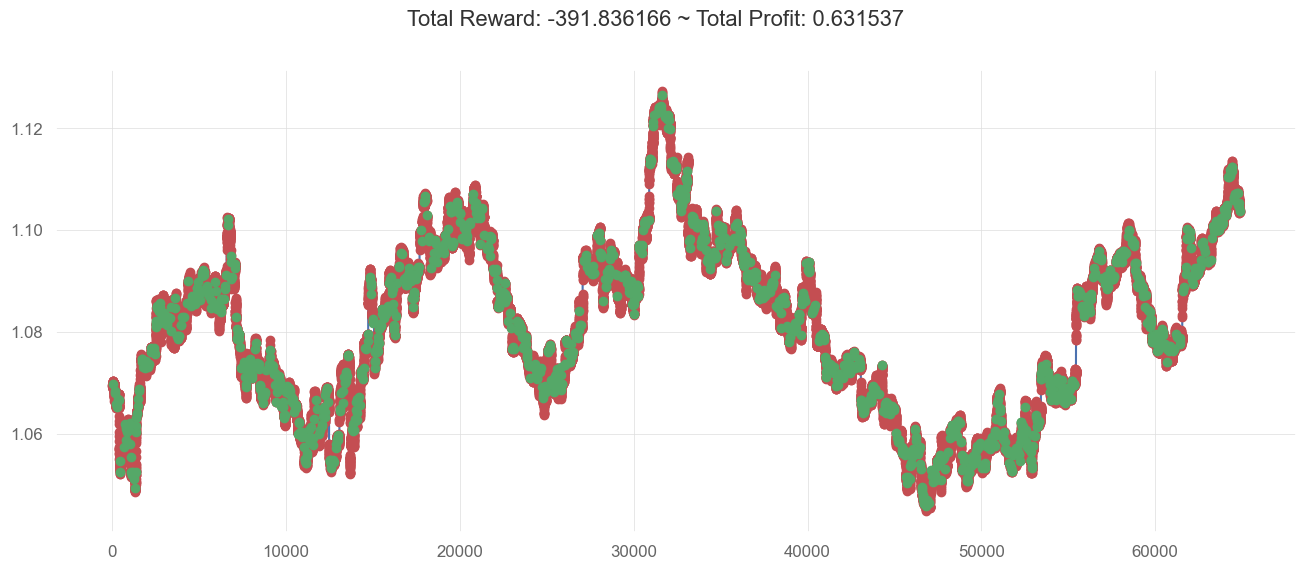

In [ ]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

timestamp
2023-01-01 17:45:00    0.000000
2023-01-01 17:46:00    0.000000
2023-01-01 17:47:00    0.000000
2023-01-01 17:48:00    0.000000
2023-01-01 17:49:00    0.000000
                         ...   
2023-03-10 04:57:00    0.000000
2023-03-10 04:58:00    0.000000
2023-03-10 04:59:00    0.000172
2023-03-10 05:00:00    0.000000
2023-03-10 05:01:00   -0.000036
Length: 64844, dtype: float64


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

                           Strategy
-------------------------  ----------
Start Period               2023-01-01
End Period                 2023-03-10
Risk-Free Rate             0.0%
Time in Market             3.0%

Cumulative Return          -36.85%
CAGR﹪                     -82.25%

Sharpe                     -0.36
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -0.36
Sortino                    -0.47
Smart Sortino              -0.47
Sortino/√2                 -0.33
Smart Sortino/√2           -0.33
Omega                      0.61

Max Drawdown               -37.93%
Longest DD Days            68
Volatility (ann.)          0.49%
Calmar                     -2.17
Skew                       -3.85
Kurtosis                   575.07

Expected Daily %           -0.0%
Expected Monthly %         -14.2%
Expected Yearly %          -36.85%
Kelly Criterion            -22.76%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.05%
Expected Shortfall (cVaR)  -0.05%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-01-02,2023-03-09,2023-03-10,68,-37.930778,-37.380511
2,2023-01-01,2023-01-01,2023-01-02,1,-0.216465,-0.195880
3,2023-01-01,2023-01-01,2023-01-01,1,-0.114027,NaN
4,2023-01-01,2023-01-01,2023-01-01,1,-0.041176,NaN


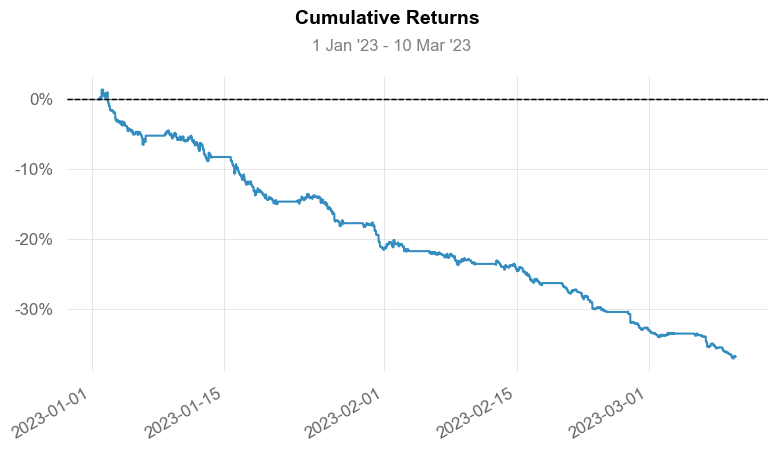

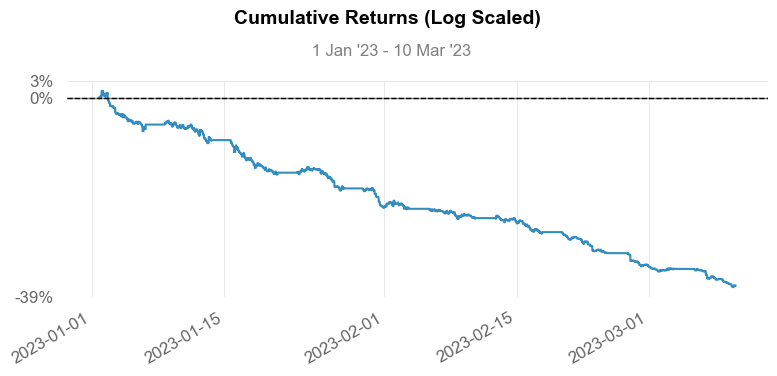

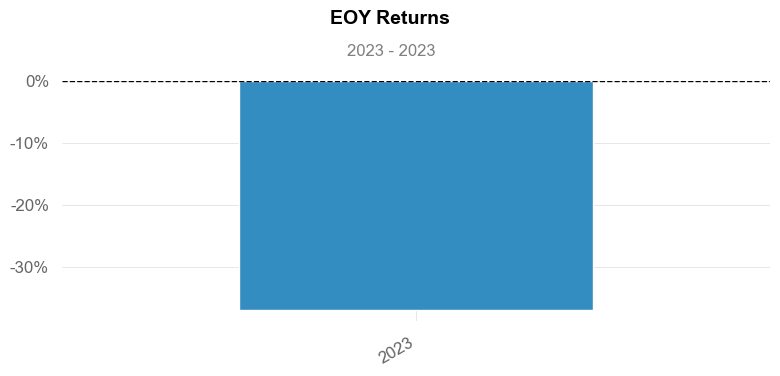

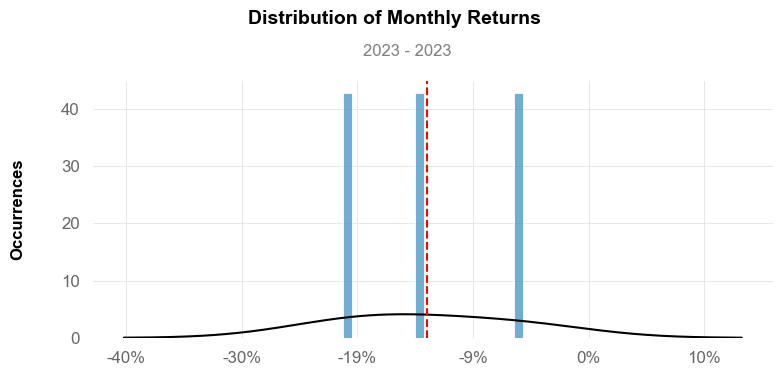

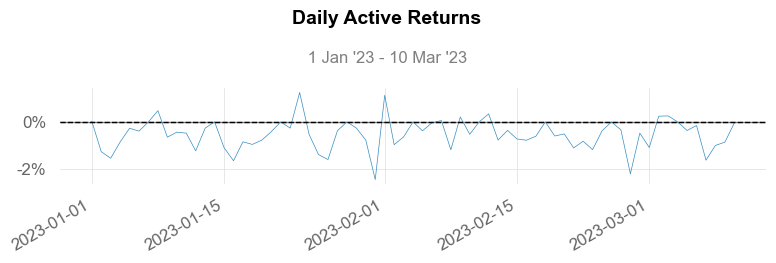

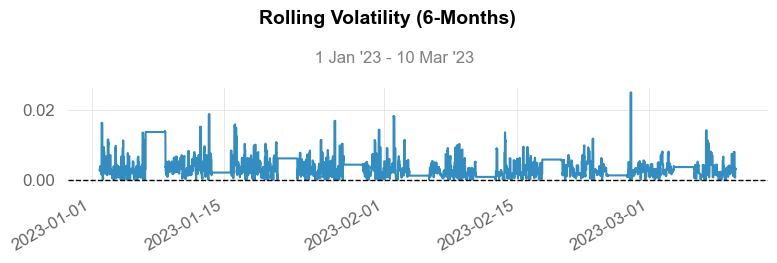

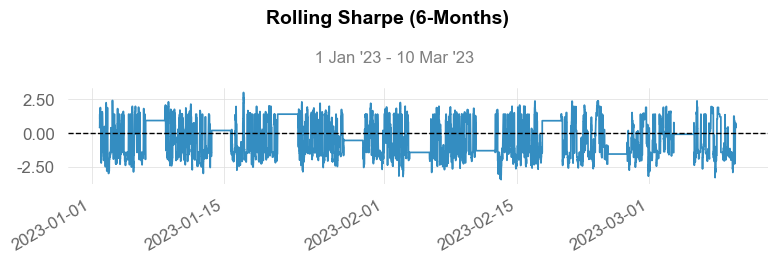

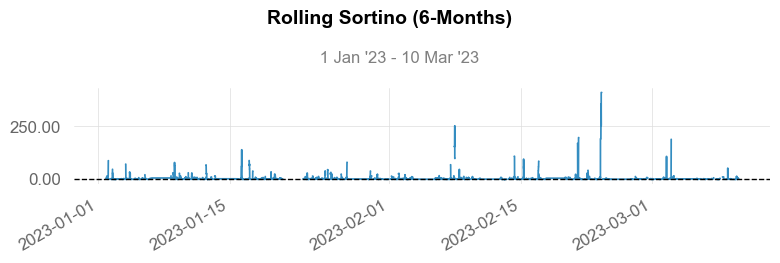

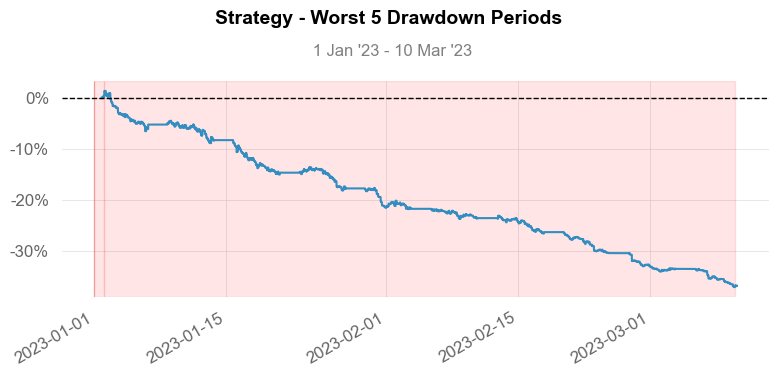

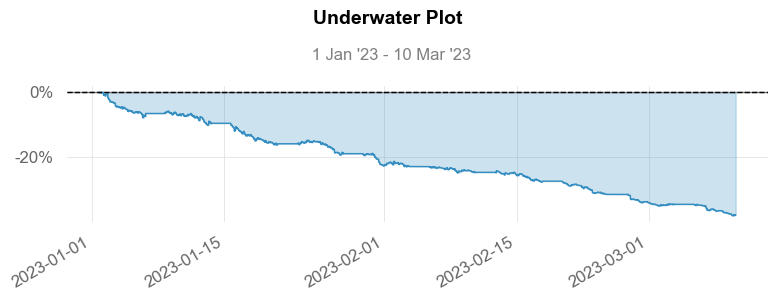

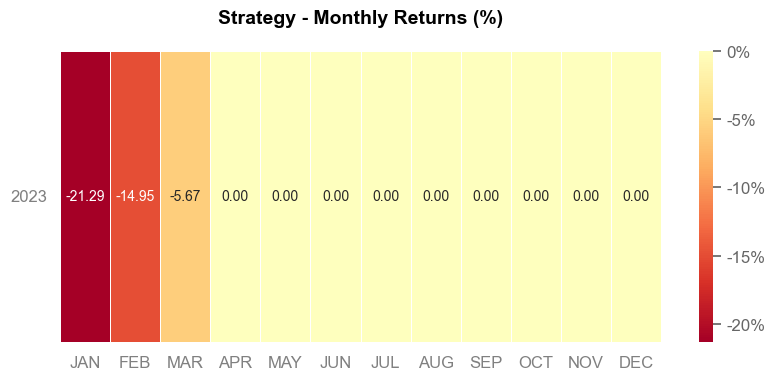

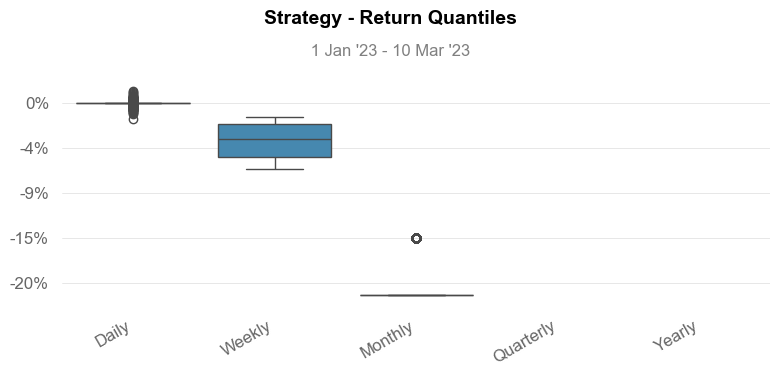

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

In [ ]:
import quantstats as qs

qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns)

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')